<a href="https://colab.research.google.com/github/andysingal/machine-learning/blob/main/Data_Science_Job_Salary_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook Color Scheme:


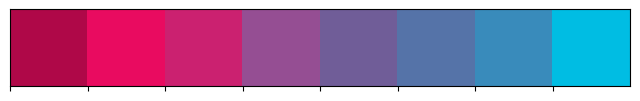

In [1]:
# Libraries
import os
import gc
import time
import random
import math
import glob
from scipy import spatial
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
from numpy import dot, sqrt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from IPython.display import display_html
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
plt.rcParams.update({'font.size': 16})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib.colors import ListedColormap

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'HandM', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'
    
my_colors = ["#AF0848", "#E90B60", "#CB2170", "#954E93", "#705D98", "#5573A8", "#398BBB", "#00BDE3"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [30]:
df = pd.read_csv('ds_salaries.csv')
print(clr.S+"Data Scientist Salary:"+clr.E, df.shape)
display_html(df.head(3)), df.columns 

Data Scientist Salary: (607, 12)


,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


(None,
 Index(['Unnamed: 0', 'work_year', 'experience_level', 'employment_type',
        'job_title', 'salary', 'salary_currency', 'salary_in_usd',
        'employee_residence', 'remote_ratio', 'company_location',
        'company_size'],
       dtype='object'))

# Data Preprocessing Part 1

In [31]:
#drop salary column because there's salary in usd column
#drop salary_currency column to make it universal by using only usd
df.drop(columns=['Unnamed: 0','salary', 'salary_currency'], inplace=True)
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


In [32]:
#Check the missing value
check_missing = df.isnull().sum() * 100 / df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

Series([], dtype: float64)

In [33]:
#Check the number of unique value on object datatype
df.select_dtypes(include='object').nunique()

experience_level       4
employment_type        4
job_title             50
employee_residence    57
company_location      50
company_size           3
dtype: int64

# Categorize the Job Title

In [34]:
df.job_title.unique()

array(['Data Scientist', 'Machine Learning Scientist',
       'Big Data Engineer', 'Product Data Analyst',
       'Machine Learning Engineer', 'Data Analyst', 'Lead Data Scientist',
       'Business Data Analyst', 'Lead Data Engineer', 'Lead Data Analyst',
       'Data Engineer', 'Data Science Consultant', 'BI Data Analyst',
       'Director of Data Science', 'Research Scientist',
       'Machine Learning Manager', 'Data Engineering Manager',
       'Machine Learning Infrastructure Engineer', 'ML Engineer',
       'AI Scientist', 'Computer Vision Engineer',
       'Principal Data Scientist', 'Data Science Manager', 'Head of Data',
       '3D Computer Vision Researcher', 'Data Analytics Engineer',
       'Applied Data Scientist', 'Marketing Data Analyst',
       'Cloud Data Engineer', 'Financial Data Analyst',
       'Computer Vision Software Engineer',
       'Director of Data Engineering', 'Data Science Engineer',
       'Principal Data Engineer', 'Machine Learning Developer',
       

In [35]:
def segment_job_title(job_title):
    data_scientist_titles = ['Principal Data Scientist', 'Data Scientist', 'Applied Scientist', 'Research Scientist', 'Applied Data Scientist', 'Lead Data Scientist', 'Staff Data Scientist', 'Principal Data Analyst', 'Principal Data Engineer']
    machine_learning_titles = ['ML Engineer', 'Machine Learning Engineer', 'Applied Machine Learning Engineer', 'Machine Learning Researcher', 'Machine Learning Scientist', 'Autonomous Vehicle Technician', 'Applied Machine Learning Scientist', 'Principal Machine Learning Engineer', 'Machine Learning Developer', 'Lead Machine Learning Engineer', 'Machine Learning Manager']
    data_analyst_titles = ['Data Analyst', 'Data Quality Analyst', 'Compliance Data Analyst', 'Business Data Analyst', 'Staff Data Analyst', 'Lead Data Analyst', 'BI Data Analyst', 'Marketing Data Analyst', 'Finance Data Analyst']
    data_engineer_titles = ['Data Modeler', 'Data Engineer', 'ETL Engineer', 'Data DevOps Engineer', 'Big Data Engineer', 'Data Infrastructure Engineer', 'Software Data Engineer', 'Cloud Database Engineer', 'Cloud Data Engineer', 'Cloud Data Architect', 'Lead Data Engineer', 'Principal Data Engineer']
    bi_analytics_titles = ['Data Analytics Manager', 'Business Intelligence Engineer', 'Analytics Engineer', 'BI Data Engineer', 'Director of Data Science', 'BI Developer', 'Insight Analyst', 'Data Analytics Specialist', 'Data Analytics Lead', 'Power BI Developer', 'Cloud Data Architect']
    other_titles = ['Data Strategist', 'Computer Vision Engineer', 'AI Developer', 'Head of Data']

    if job_title in data_scientist_titles:
        return 'Data Scientist'
    elif job_title in machine_learning_titles:
        return 'Machine Learning Engineer'
    elif job_title in data_analyst_titles:
        return 'Data Analyst'
    elif job_title in data_engineer_titles:
        return 'Data Engineer'
    elif job_title in bi_analytics_titles:
        return 'Business Intelligence and Analytics'
    elif job_title in other_titles:
        return 'Other'
    else:
        return 'Uncategorized'

In [36]:
df['job_title'] = df['job_title'].apply(segment_job_title)

<Axes: >

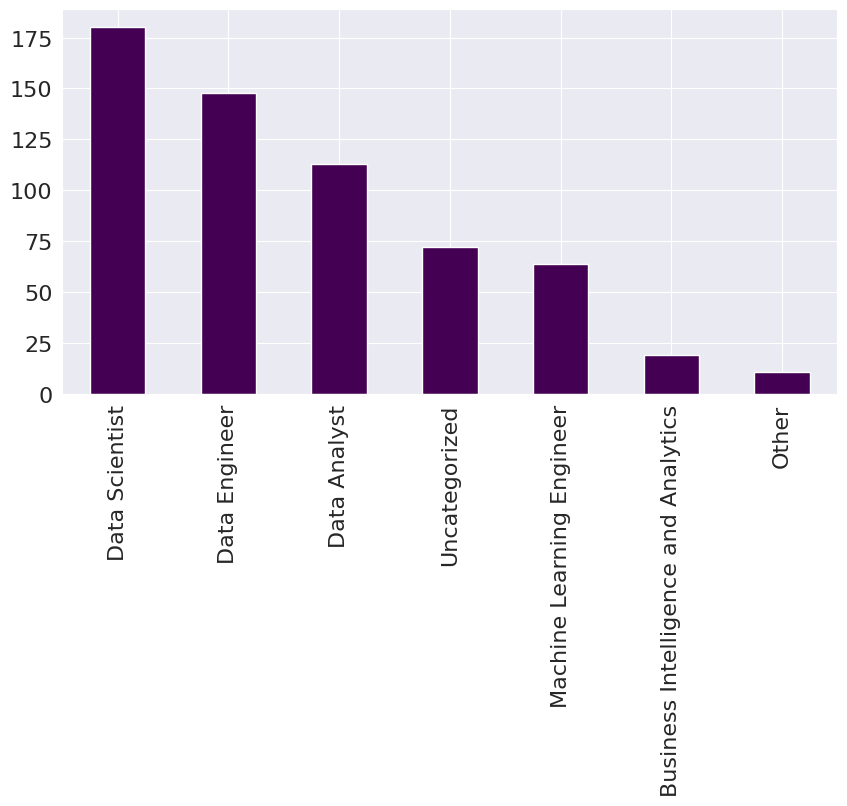

In [39]:
plt.figure(figsize=(10,5))
df['job_title'].value_counts().plot(kind='bar',cmap='viridis')

# Categorize the Employee Residence

In [40]:
df.employee_residence.unique()

array(['DE', 'JP', 'GB', 'HN', 'US', 'HU', 'NZ', 'FR', 'IN', 'PK', 'PL',
       'PT', 'CN', 'GR', 'AE', 'NL', 'MX', 'CA', 'AT', 'NG', 'PH', 'ES',
       'DK', 'RU', 'IT', 'HR', 'BG', 'SG', 'BR', 'IQ', 'VN', 'BE', 'UA',
       'MT', 'CL', 'RO', 'IR', 'CO', 'MD', 'KE', 'SI', 'HK', 'TR', 'RS',
       'PR', 'LU', 'JE', 'CZ', 'AR', 'DZ', 'TN', 'MY', 'EE', 'AU', 'BO',
       'IE', 'CH'], dtype=object)

In [41]:
# Define a function to categorize the unique values
def categorize_region(country):
    if country in ['DE', 'GB', 'PT', 'NL', 'CH', 'CF', 'FR', 'FI', 'UA', 'IE', 'AT', 'SG', 'SE', 'SI', 'UZ', 'HR', 'PL', 'CY', 'AM', 'BA', 'GR', 'MK', 'LV', 'RO', 'IT', 'MA', 'LT', 'BE', 'AS', 'HU', 'SK', 'CZ', 'JE', 'RS', 'MD', 'LU', 'MT']:
        return 'Europe'
    elif country in ['US', 'CA', 'MX']:
        return 'North America'
    elif country in ['BR', 'AR', 'CL', 'BO', 'CR', 'DO', 'PR', 'HN', 'UY']:
        return 'South America'
    elif country in ['NG', 'GH', 'KE', 'TN', 'DZ']:
        return 'Africa'
    elif country in ['HK', 'IN', 'CN', 'JP', 'KR', 'BD', 'VN', 'PH', 'MY', 'ID', 'AE']:
        return 'Asia'
    elif country in ['AU', 'NZ']:
        return 'Oceania'
    else:
        return 'Unknown'

# Apply the function to the "employee residence" column to create a new column with the categorized values
df['employee_residence'] = df['employee_residence'].apply(categorize_region)

<Axes: >

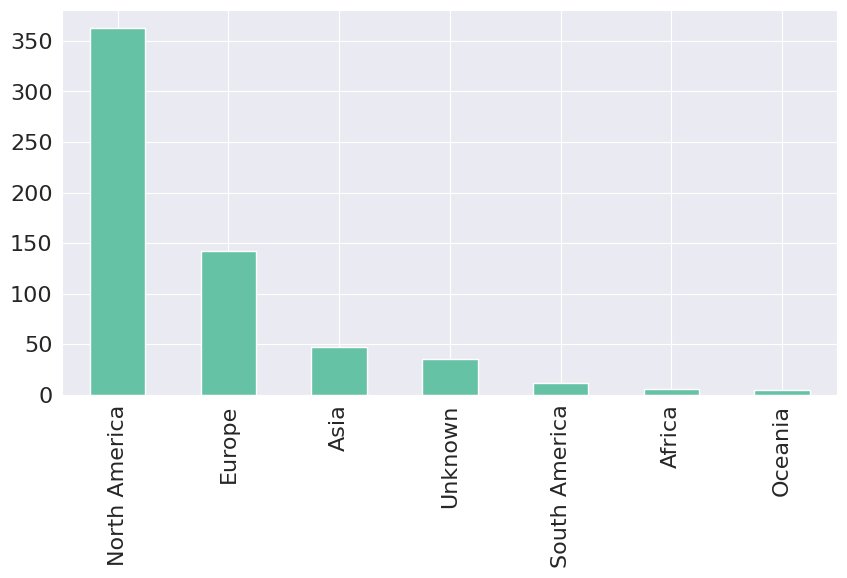

In [42]:
plt.figure(figsize=(10,5))
df['employee_residence'].value_counts().plot(kind='bar')

# Categorize the Company Location

In [43]:
df.company_location.unique()

array(['DE', 'JP', 'GB', 'HN', 'US', 'HU', 'NZ', 'FR', 'IN', 'PK', 'CN',
       'GR', 'AE', 'NL', 'MX', 'CA', 'AT', 'NG', 'ES', 'PT', 'DK', 'IT',
       'HR', 'LU', 'PL', 'SG', 'RO', 'IQ', 'BR', 'BE', 'UA', 'IL', 'RU',
       'MT', 'CL', 'IR', 'CO', 'MD', 'KE', 'SI', 'CH', 'VN', 'AS', 'TR',
       'CZ', 'DZ', 'EE', 'MY', 'AU', 'IE'], dtype=object)

In [44]:
# Define a function to categorize the unique values
def categorize_region(country):
    if country in ['DE', 'GB', 'PT', 'NL', 'CH', 'CF', 'FR', 'FI', 'UA', 'IE', 'AT', 'SG', 'SE', 'SI', 'UZ', 'HR', 'PL', 'CY', 'AM', 'BA', 'GR', 'MK', 'LV', 'RO', 'IT', 'MA', 'LT', 'BE', 'AS', 'HU', 'SK', 'CZ', 'JE', 'RS', 'MD', 'LU', 'MT']:
        return 'Europe'
    elif country in ['US', 'CA', 'MX']:
        return 'North America'
    elif country in ['BR', 'AR', 'CL', 'BO', 'CR', 'DO', 'PR', 'HN', 'UY']:
        return 'South America'
    elif country in ['NG', 'GH', 'KE', 'TN', 'DZ']:
        return 'Africa'
    elif country in ['HK', 'IN', 'CN', 'JP', 'KR', 'BD', 'VN', 'PH', 'MY', 'ID', 'AE']:
        return 'Asia'
    elif country in ['AU', 'NZ']:
        return 'Oceania'
    else:
        return 'Unknown'

# Apply the function to the "company_location" column to create a new column with the categorized values
df['company_location'] = df['company_location'].apply(categorize_region)

<Axes: >

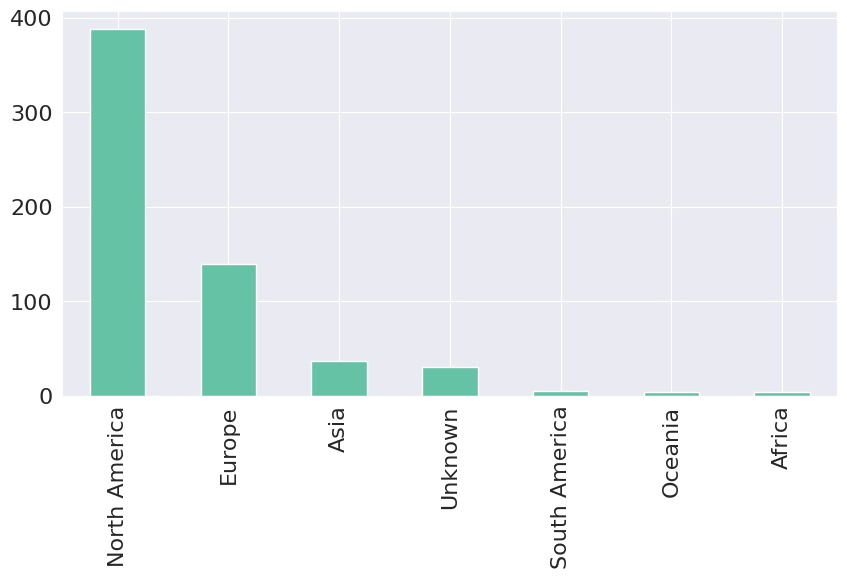

In [45]:
plt.figure(figsize=(10,5))
df['company_location'].value_counts().plot(kind='bar')

In [46]:
#Check the number of unique value on object datatype
df.select_dtypes(include='object').nunique()

experience_level      4
employment_type       4
job_title             7
employee_residence    7
company_location      7
company_size          3
dtype: int64

# Exploratory Data Analysis

In [48]:
df.remote_ratio.unique()

array([  0,  50, 100])

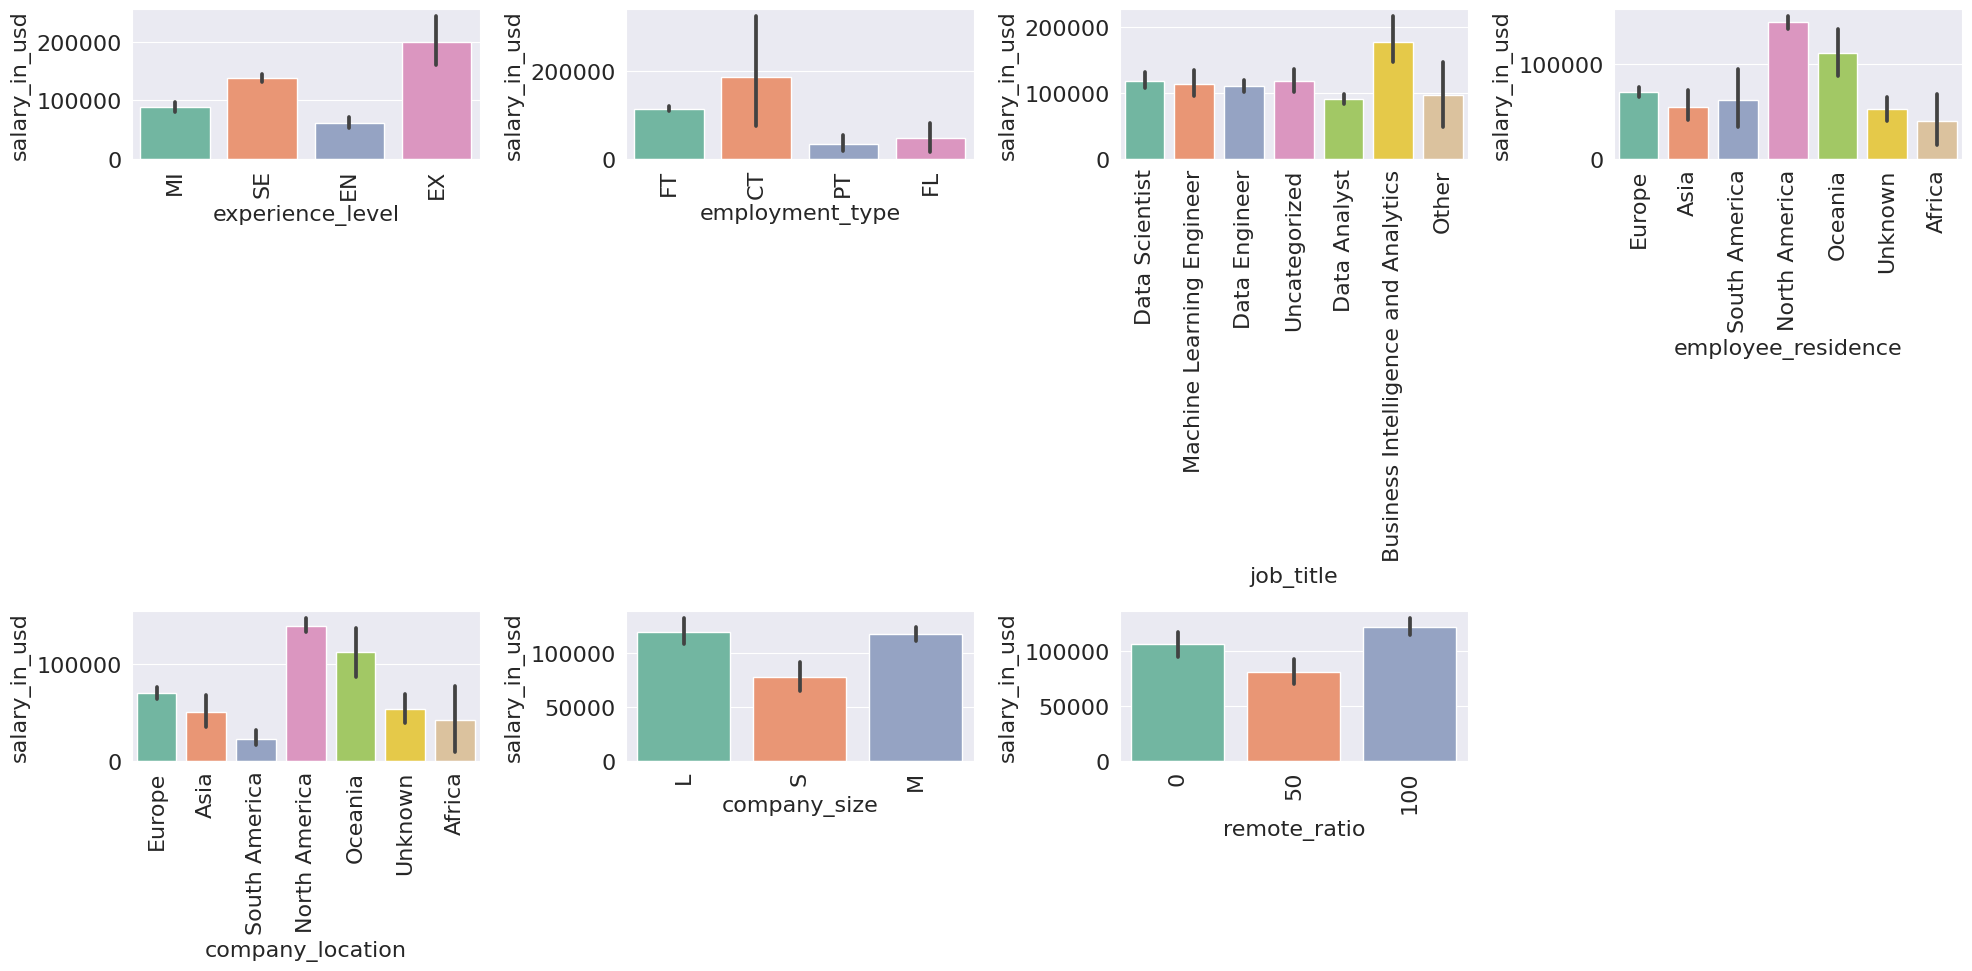

In [49]:
# list of categorical variables to plot
cat_vars = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 
            'company_location', 'company_size', 'remote_ratio']

# create figure with subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axs = axs.flatten()

# create barplot for each categorical variable
for i, var in enumerate(cat_vars):
    sns.barplot(x=var, y='salary_in_usd', data=df, ax=axs[i], estimator=np.mean)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# remove the eighth subplot
fig.delaxes(axs[7])

# adjust spacing between subplots
fig.tight_layout()

# show plot
plt.show()

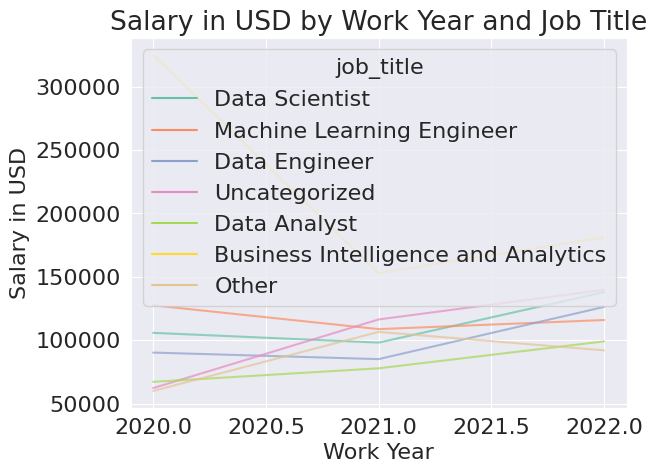

In [50]:
sns.set_style("darkgrid")
sns.set_palette("Set2")

sns.lineplot(x='work_year', y='salary_in_usd', hue='job_title', data=df, ci=None, estimator='mean', alpha=0.7)

plt.title("Salary in USD by Work Year and Job Title")
plt.xlabel("Work Year")
plt.ylabel("Salary in USD")

plt.show()

# Data Preprocessing Part 2

# Label Encoding for Object datatype

In [51]:
# Loop over each column in the DataFrame where dtype is 'object'
for col in df.select_dtypes(include=['object']).columns:
    
    # Print the column name and the unique values
    print(f"{col}: {df[col].unique()}")

experience_level: ['MI' 'SE' 'EN' 'EX']
employment_type: ['FT' 'CT' 'PT' 'FL']
job_title: ['Data Scientist' 'Machine Learning Engineer' 'Data Engineer'
 'Uncategorized' 'Data Analyst' 'Business Intelligence and Analytics'
 'Other']
employee_residence: ['Europe' 'Asia' 'South America' 'North America' 'Oceania' 'Unknown'
 'Africa']
company_location: ['Europe' 'Asia' 'South America' 'North America' 'Oceania' 'Unknown'
 'Africa']
company_size: ['L' 'S' 'M']


In [52]:
from sklearn import preprocessing

# Loop over each column in the DataFrame where dtype is 'object'
for col in df.select_dtypes(include=['object']).columns:
    
    # Initialize a LabelEncoder object
    label_encoder = preprocessing.LabelEncoder()
    
    # Fit the encoder to the unique values in the column
    label_encoder.fit(df[col].unique())
    
    # Transform the column using the encoder
    df[col] = label_encoder.transform(df[col])
    
    # Print the column name and the unique encoded values
    print(f"{col}: {df[col].unique()}")

experience_level: [2 3 0 1]
employment_type: [2 0 3 1]
job_title: [3 4 2 6 1 0 5]
employee_residence: [2 1 5 3 4 6 0]
company_location: [2 1 5 3 4 6 0]
company_size: [0 2 1]


In [53]:
df.dtypes

work_year             int64
experience_level      int64
employment_type       int64
job_title             int64
salary_in_usd         int64
employee_residence    int64
remote_ratio          int64
company_location      int64
company_size          int64
dtype: object

# All of the data are categorial so that means, there are no outliers

<Axes: >

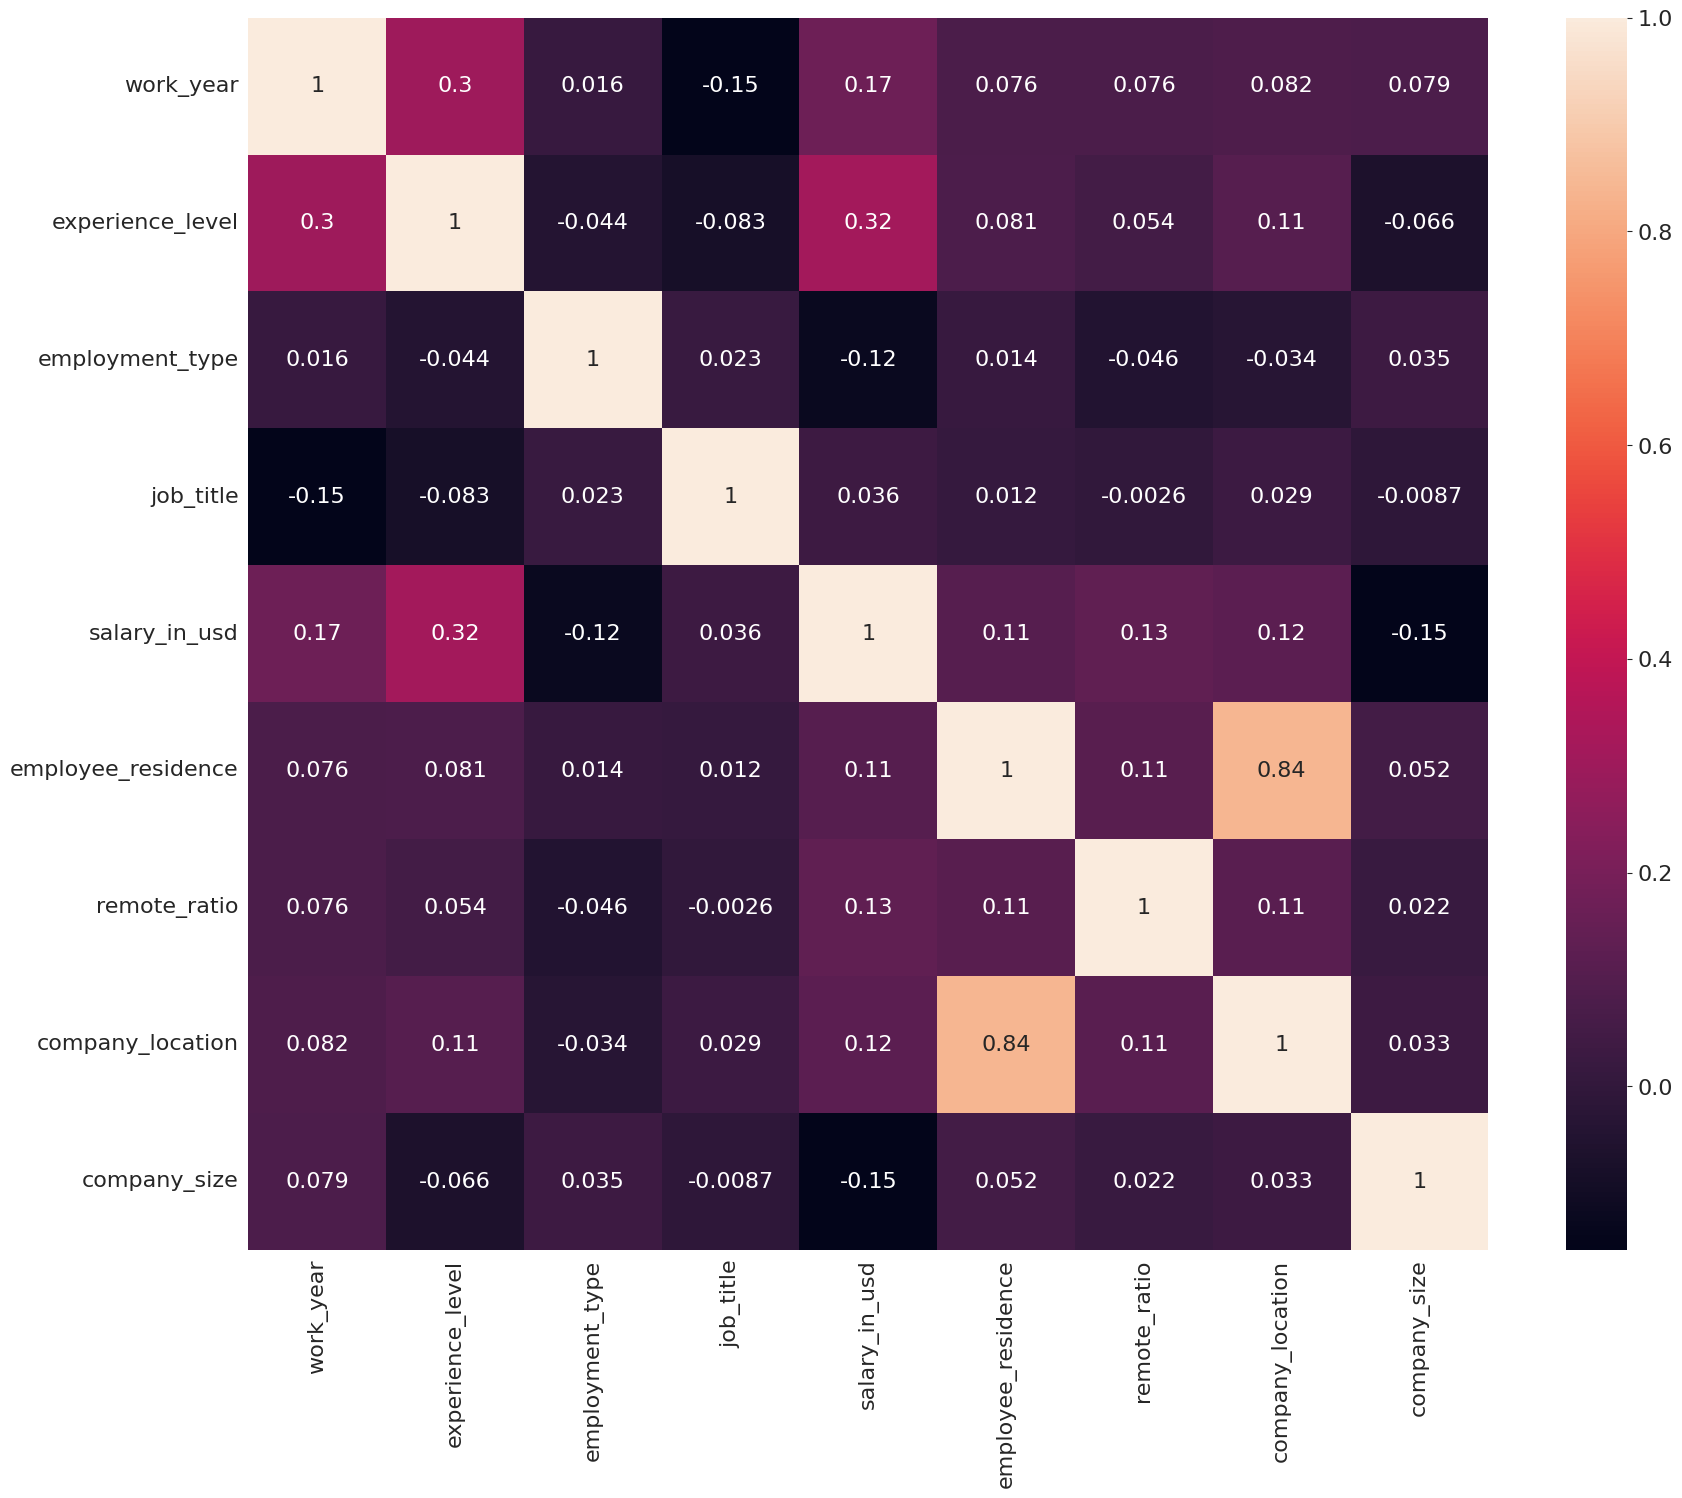

In [54]:
#Correlation Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), fmt='.2g', annot=True)

# Train test Split

In [55]:
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']

In [56]:
#test size 20% and train size 80%
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

# Decision Tree Regressor

In [58]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV



# Create a DecisionTreeRegressor object
dtree = DecisionTreeRegressor()

# Define the hyperparameters to tune and their values
param_grid = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6}


In [59]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(random_state=0, max_depth=6, max_features='auto', min_samples_leaf=3, min_samples_split=4)
dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, max_features='auto', min_samples_leaf=3,
                      min_samples_split=4, random_state=0)

In [60]:
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import math
y_pred = dtree.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
rmse = math.sqrt(mse)

print('MAE is {}'.format(mae))
print('MAPE is {}'.format(mape))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
print('RMSE score is {}'.format(rmse))

MAE is 40715.01470287748
MAPE is 0.6990844726640965
MSE is 3553613380.5460386
R2 score is 0.4438804660149036
RMSE score is 59612.1915428886


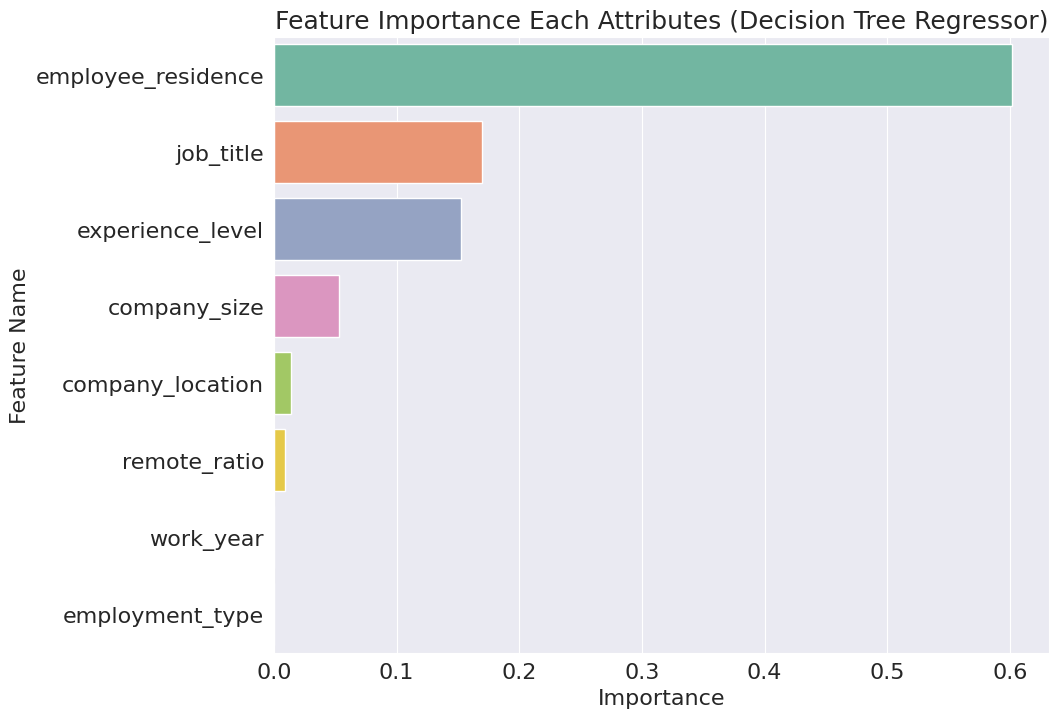

In [61]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": dtree.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (Decision Tree Regressor)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

In [63]:
%%capture
!pip install shap

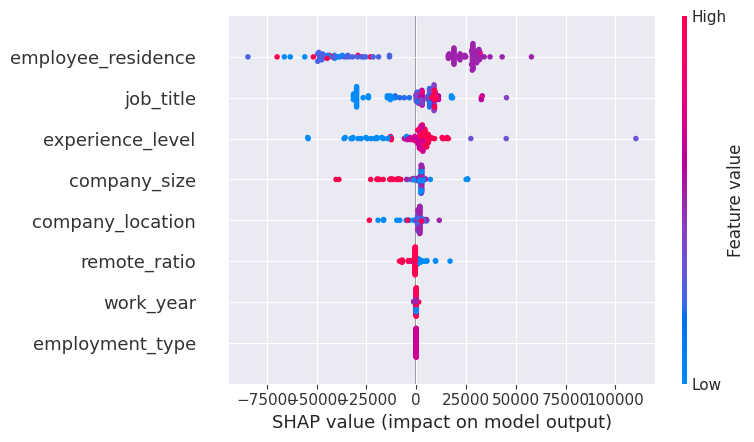

In [64]:
import shap
explainer = shap.TreeExplainer(dtree)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

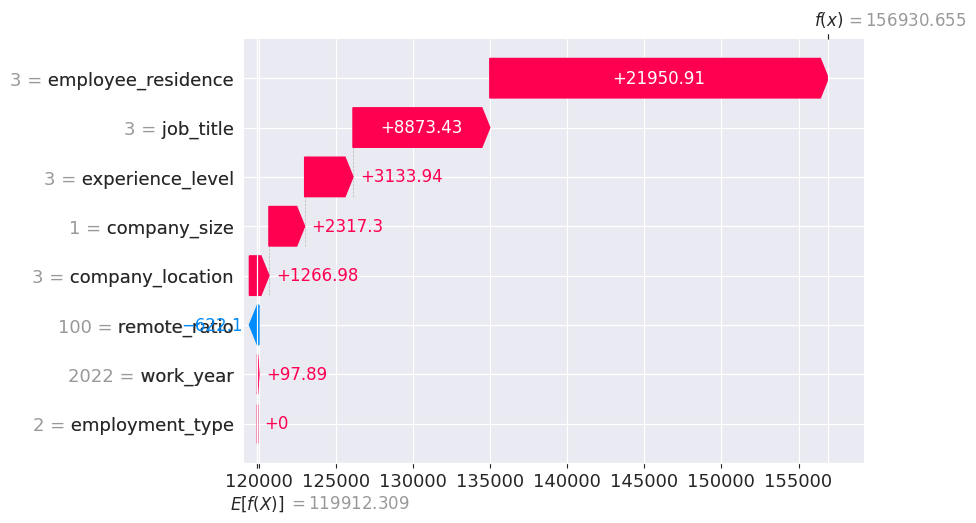

In [65]:
explainer = shap.Explainer(dtree, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])

# Random Forest Regressor

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create a Random Forest Regressor object
rf = RandomForestRegressor()

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}


In [67]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=0, max_depth=7, min_samples_split=10, min_samples_leaf=2, 
                           max_features='auto')
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, max_features='auto', min_samples_leaf=2,
                      min_samples_split=10, random_state=0)

In [68]:
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import math
y_pred = rf.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
rmse = math.sqrt(mse)

print('MAE is {}'.format(mae))
print('MAPE is {}'.format(mape))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
print('RMSE score is {}'.format(rmse))

MAE is 39247.926609617054
MAPE is 0.6714968719109814
MSE is 3667697837.6273136
R2 score is 0.4260269213793775
RMSE score is 60561.521097371005


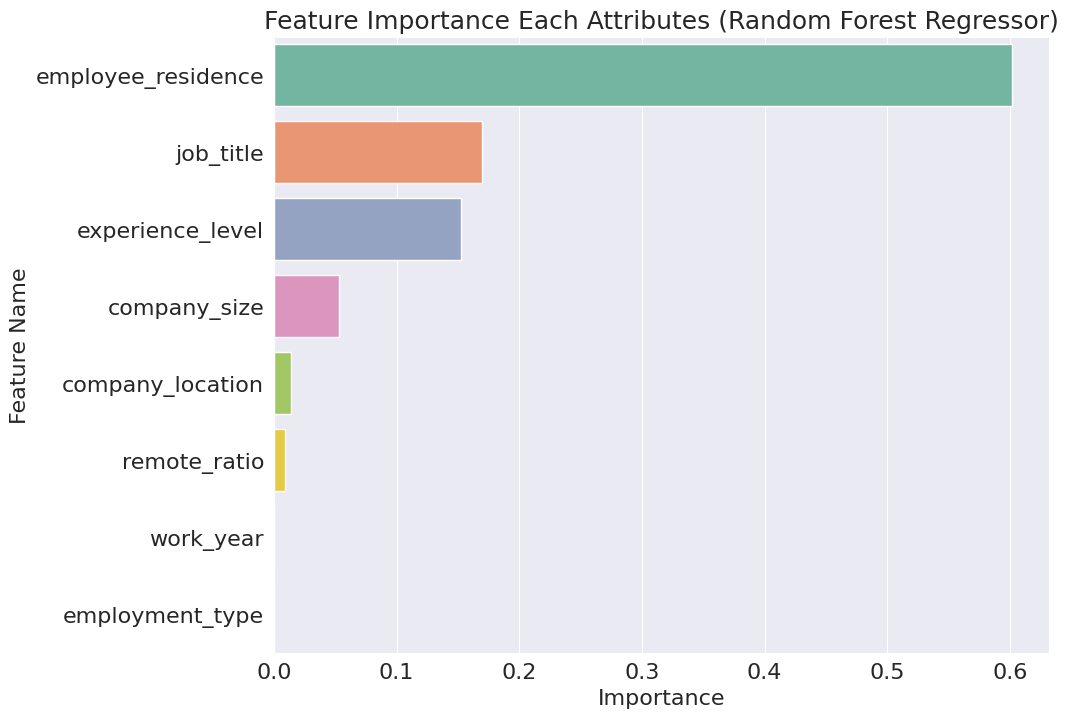

In [69]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": dtree.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (Random Forest Regressor)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

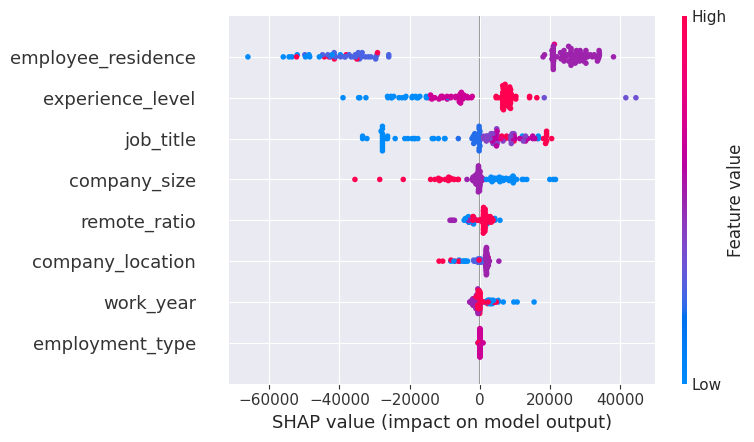

In [70]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

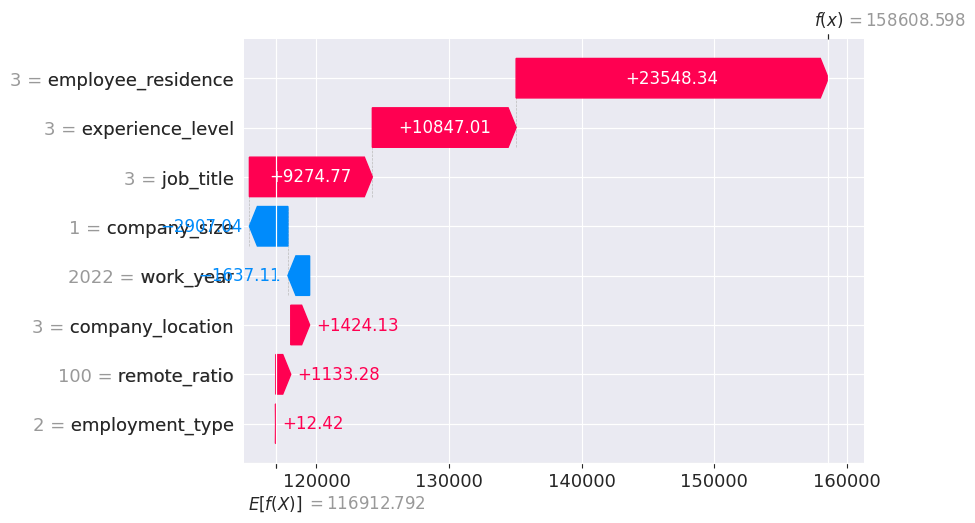

In [71]:
explainer = shap.Explainer(rf, X_test, check_additivity=False)
shap_values = explainer(X_test, check_additivity=False)
shap.plots.waterfall(shap_values[0])